In MC development, the key idea is to estimate the expected return by averaging rewards observed in enough number of episodes. We need to do comparison between the value of different actions given one state to improve the policy. However, V_pi fails to offer enough information and thus it is not useful. We use Q_pi instead, which provides an estimate of the expected return given a specific action.

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [ ]:
!apt-get install -y xvfb

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.12).
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

Reward using trained policy: 84.0


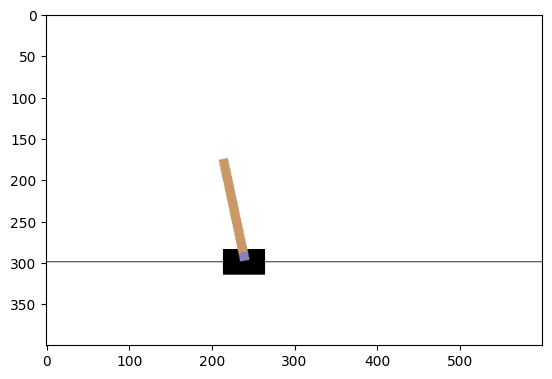

In [ ]:
# Discretization
def discretize_state(state, bins):

  cart_pos_bin = np.digitize(state[0], bins[0])
  cart_vel_bin = np.digitize(state[1], bins[1])
  pole_ang_bin = np.digitize(state[2], bins[2])
  pole_vel_bin = np.digitize(state[3], bins[3])

  return (cart_pos_bin, cart_vel_bin, pole_ang_bin, pole_vel_bin)

bins = [
  np.linspace(-2.4, 2.4, 4),     # car position
  np.linspace(-2, 2, 8),       # car velocity
  np.linspace(-0.2095, 0.2095, 10),  # pole angle
  np.linspace(-5, 5, 10)       # pole angular velocity
]

# Initialization
env = gym.make("CartPole-v0")
stateSpaceSize = (len(bins[0])+1, len(bins[1])+1, len(bins[2])+1, len(bins[3])+1)
actionSpaceSize = env.action_space.n
Q, C = np.zeros(stateSpaceSize + (actionSpaceSize,)), np.zeros(stateSpaceSize + (actionSpaceSize,))
gamma, episodes = 0.99, 1000000

for episode in range(episodes):
  state = env.reset()
  state = discretize_state(state, bins)
  trajectory = []
  done = False

  while not done:
    action = np.random.choice(actionSpaceSize)
    next_state, reward, done, _ = env.step(action)
    next_state = discretize_state(next_state, bins)
    trajectory.append((state, action, reward))
    state = next_state

  # Importance sampling
  G, W = 0, 1
  for t in reversed(range(len(trajectory))):
    state, action, reward = trajectory[t]
    G = gamma * G + reward
    C[state][action] += W
    Q[state][action] += (W / C[state][action]) * (G - Q[state][action])
    if action != np.argmax(Q[state]):
      break
    W *= 1 / (1 / actionSpaceSize)

state = env.reset()
state = discretize_state(state, bins)
done = False
i, total_reward = 0, 0
while not done:
  env.render()
  action = np.argmax(Q[state])
  print("step i",i,"action=",action)
  i += 1
  state, reward, done, info = env.step(action)
  print("obs=",state,"reward=",reward,"done=",done,"info=",info)
  screen = env.render(mode='rgb_array')
  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())
  state = discretize_state(state, bins)
  total_reward += reward
ipythondisplay.clear_output(wait=True)
print('Reward using trained policy:', total_reward)
env.close()


Algorithm for MC Control (Off Policy) is coded above.
I runned the code starting from 100,000 episodes, and the reward grows steadily from 40+.
After 1,000,000 episodes (which takes approximately half an hour), the reward we can achieve is close to 100.
There is still a huge gap between this result and our goal (balance it indefinitely), but I think with more episodes and discretization to be better tuned, we can finally reach that goal.